# RoBERTa-large
https://huggingface.co/FacebookAI/xlm-roberta-base

In [1]:
!nvidia-smi

Mon Mar  3 18:31:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:C2:00.0 Off |                   On |
| N/A   33C    P0              63W / 300W |  15218MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [2]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List
from datetime import datetime
import pickle
import seaborn as sns


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_DIR = "/vol/bitbucket/rk1121/nlp/models"
raw_dir = f"{MODEL_DIR}/raw"
basic_finetuned_dir = f"{MODEL_DIR}/basic_finetuned"
weighted_loss_dir = f"{MODEL_DIR}/weighted_loss"
weighted_sampler_dir = f"{MODEL_DIR}/weighted_sampler"
weighted_loss_sampler_dir = f"{MODEL_DIR}/weighted_loss_sampler"
augmented_dir = f"{MODEL_DIR}/augmented"
combined_dir = f"{MODEL_DIR}/combined"
optimal_dir = f"{MODEL_DIR}/optimal"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load RoBERTa-large

In [4]:
MODEL_NAME = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [5]:
# Load tokenizer and model
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 

model.to(device)
model.save_pretrained(raw_dir)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load raw text data

In [6]:
def convert_to_binary(label: Any) -> int:
    """
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """
    # If label_array is a string, convert it to a list
    return 0 if label == 0 or label == 1 else 1 

In [7]:
TRAIN_DATA_PATH = "data/dontpatronizeme_pcl.tsv"
TRAIN_ALLOC_PATH = "data/train_semeval_parids-labels.csv"
DEV_ALLOC_PATH = "data/dev_semeval_parids-labels.csv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t", header=None, names=column_names)
text_data["label"] = text_data["orig_label"].apply(convert_to_binary)

print("Text Data shape:", text_data.shape)

train_alloc = pd.read_csv(TRAIN_ALLOC_PATH).drop("label", axis=1)
official_dev_alloc = pd.read_csv(DEV_ALLOC_PATH).drop("label", axis=1)
print("Train Allocation shape:", train_alloc.shape)
print("Official Dev Allocation shape:", official_dev_alloc.shape)

train_data = pd.merge(train_alloc, text_data, on="par_id")
official_dev_data = pd.merge(official_dev_alloc, text_data, on="par_id")
print("Merged Train Data shape:", train_data.shape)
print("Merged Official Dev Data shape:", official_dev_data.shape)

Text Data shape: (10469, 7)
Train Allocation shape: (8375, 1)
Official Dev Allocation shape: (2094, 1)
Merged Train Data shape: (8375, 7)
Merged Official Dev Data shape: (2094, 7)


### (Pre-)Tokenize Dataset

In [8]:
def tokenize(text, tokenizer, max_length=128):
  return tokenizer(
    str(text),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )

In [15]:
pretokenized_data = []
for index, row in train_data.iterrows():
  tokenized = tokenize(row["text"], tokenizer)
  tokenized = { key : value.squeeze(0).clone() for key, value in tokenized.items() }
  tokenized["labels"] = row["label"]
  tokenized["text"] = row["text"]
  pretokenized_data.append(tokenized)

with open("pretokenized.pkl", "wb") as f:
  pickle.dump(pretokenized_data, f)

### Load into DataLoader's

In [9]:
class DontPatronizeMeDataset(Dataset):
  def __init__(self, data, tokenizer = None, max_length=128):
    self.tokenizer = tokenizer

    if self.tokenizer is not None:
      self.max_length = max_length
      self.data = data.reset_index(drop = True)
    else:
      self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    if self.tokenizer is not None:
      text = str(self.data.loc[idx, "text"])
      label = self.data.loc[idx, "label"]

      encoding = self.tokenizer(
        text, 
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
      )

      encoding = { key: value.squeeze(0) for key, value in encoding.items() }
      encoding["labels"] = torch.tensor(label, dtype=torch.long)

      return encoding
    else:
      item = self.data[idx]
      item.pop("text", None)
      return item


In [10]:
with open("pretokenized.pkl", "rb") as f:
  pretokenized_data = pickle.load(f)

labels = [int(item["labels"]) for item in pretokenized_data]

internal_train_data, internal_test_data = train_test_split(
  pretokenized_data,
  test_size = 0.2,
  random_state = 16,
  stratify=labels
)

train_dataset = DontPatronizeMeDataset(internal_train_data)
test_dataset = DontPatronizeMeDataset(internal_test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

## Data Visualisation

### See if there is class imabalance

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

def visualise_imbalance(train_data, test_data, with_aug=False):
  train_labels = [int(item["labels"]) for item in train_data]
  test_labels = [int(item["labels"]) for item in test_data]

  train_counts = Counter(train_labels)
  test_counts = Counter(test_labels)

  train_sorted = { k : v for k, v in sorted(train_counts.items()) }
  test_sorted = { k : v for k, v in sorted(test_counts.items()) }

  print("--- Train ---")
  print(train_sorted)
  train_total = sum(train_counts.values())
  print({ k: f"{(100 * v / train_total):.2f}%" for k, v in train_sorted.items() })

  print("--- Test ---")
  print(test_sorted)
  test_total = sum(test_counts.values())
  print({ k: f"{(100 * v / test_total):.2f}%" for k, v in test_sorted.items() })

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

  axes[0].bar(list(train_sorted.keys()), list(train_sorted.values()), color='skyblue')
  axes[0].set_title(f'Train Data Label Distribution {"(with Data Augmentation)" if with_aug else ""}')
  axes[0].set_xlabel('Label')
  axes[0].set_ylabel('Count')

  axes[1].bar(list(test_sorted.keys()), list(test_sorted.values()), color='salmon')
  axes[1].set_title(f'Test Data Label Distribution')
  axes[1].set_xlabel('Label')
  axes[1].set_ylabel('Count')

  plt.tight_layout()
  plt.show()

--- Train ---
{0: 6065, 1: 635}
{0: '90.52%', 1: '9.48%'}
--- Test ---
{0: 1516, 1: 159}
{0: '90.51%', 1: '9.49%'}


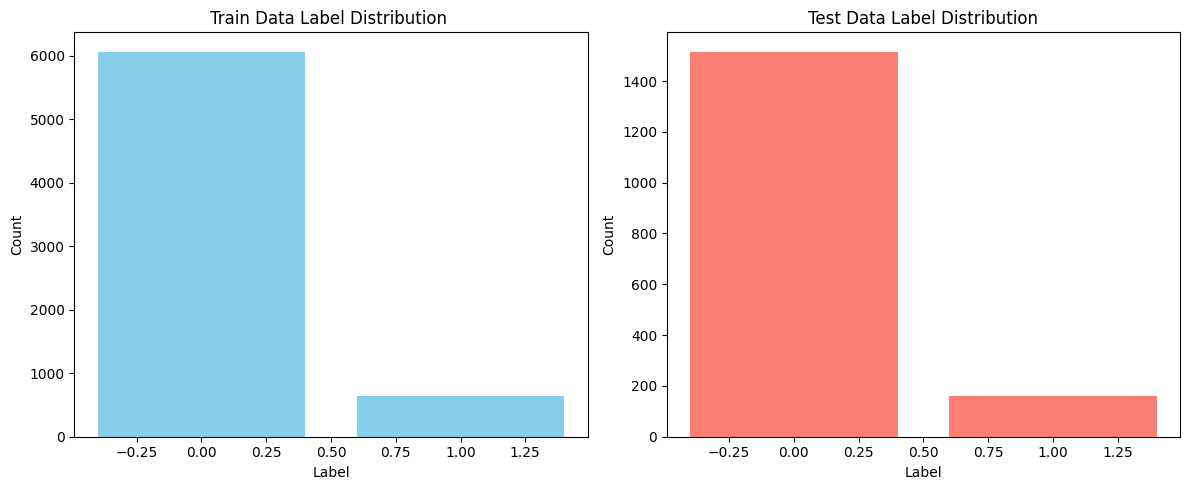

In [20]:
visualise_imbalance(internal_train_data, internal_test_data)

### Define evaluation/prediciton loops

In [12]:
def predict(model, loader: DataLoader, save_path: str = None):
  model.eval()

  predictions = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(inputs, attention_mask=attention_mask)
      logits = outputs.logits

      preds = torch.argmax(logits, dim=1)
      predictions.extend(preds.cpu().numpy().tolist())
  
  if save_path is not None:
    with open(save_path, "w") as f:
      for prediction in predictions:
        f.write(f"{prediction}\n")

  return predictions

In [13]:
def evaluate(model, loader: DataLoader, plot_confusion: bool = False):
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
      for batch in loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(inputs, attention_mask=attention_mask)
          logits = outputs.logits

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.cpu().numpy().tolist())
          y_pred.extend(predictions.cpu().numpy().tolist())

  # # Convert to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average="macro")

  if plot_confusion:
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(6,5))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
      plt.title("Confusion Matrix")
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.show()

  # predictions, labels = predict(model, loader=loader, with_labels=True, save_path=save_path)

  # Compute metrics
  # accuracy = accuracy_score(labels, predictions)
  # f1 = f1_score(labels, predictions, average="macro")

  return accuracy, f1

### Baseline Evaluation

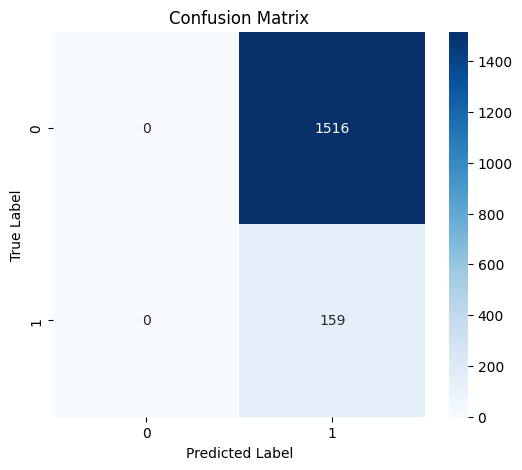

Test Accuracy: 0.094925
Test F1 Score: 0.086696


In [ ]:
model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: 0.094925
# F1:  0.086696
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

### Define training loop

In [14]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title = ""):
  epochs = list(range(1, len(train_losses) + 1))
  fig, ax1 = plt.subplots(figsize=(8, 6))

  color_train = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Training Loss', color=color_train)
  ax1.plot(epochs, train_losses, color=color_train, marker='o', label='Training Loss')
  ax1.tick_params(axis='y', labelcolor=color_train)

  # Create a second y-axis for the validation loss
  ax2 = ax1.twinx()
  color_val = 'tab:red'
  ax2.set_ylabel('Validation Loss', color=color_val)
  ax2.plot(epochs, val_losses, color=color_val, marker='o', label='Validation Loss')
  ax2.tick_params(axis='y', labelcolor=color_val)

  plt.title(title)
  fig.tight_layout()  # Adjust layout to ensure everything fits nicely
  plt.show()

In [15]:
from torch.amp import autocast, GradScaler

def finetune(
  model, 
  loader: DataLoader, 
  num_epochs: int = 10, 
  lr: float = 2e-5, 
  patience: int = 2,
  plot: bool = True,
  plot_title: str = "",
  loss_function = None
):

  best_val_loss = float("inf")
  epochs_no_improv = 0

  optimiser = optim.AdamW(model.parameters(), lr=lr)
  total_steps = len(loader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(
    optimiser, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
  )

  train_losses = []
  val_losses = []

  scaler = GradScaler(device="cuda")

  timestamp = datetime.now().strftime("%H:%M:%S")
  print(f"{timestamp} - num_epochs = {num_epochs} | lr = {lr} | patience = {patience}")

  for epoch in range(num_epochs):
    model.train()
    total_loss: float = 0.0

    for batch in loader:
      optimiser.zero_grad()

      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # Use `autocast` for mixed precision forward pass
      with autocast(device_type="cuda"):
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        if loss_function is None:
          loss = outputs.loss
        else:
          logits = outputs.logits
          loss = loss_function(logits, labels)

      scaler.scale(loss).backward()
      scaler.step(optimiser)
      scheduler.step()
      scaler.update()

      total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
      for batch in loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast(device_type="cuda"):
          outputs = model(inputs, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(loader)
    val_losses.append(avg_val_loss)

    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"{timestamp} - Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_loss:.6f} | Validation Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improv = 0
      best_model_state = model.state_dict()

    else:
      epochs_no_improv += 1
      if epochs_no_improv >= patience:
        print(f"Stopping at epoch {epoch}...")
        break
    
  model.load_state_dict(best_model_state)

  if plot:
    plot_losses(train_losses, val_losses, title=plot_title)
    

### Baseline Finetune

18:57:50 - num_epochs = 3 | lr = 2e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


19:01:08 - Epoch 1/3 | Train Loss: 0.306007 | Validation Loss: 0.211749
19:04:24 - Epoch 2/3 | Train Loss: 0.199184 | Validation Loss: 0.126961
19:07:40 - Epoch 3/3 | Train Loss: 0.106753 | Validation Loss: 0.050007


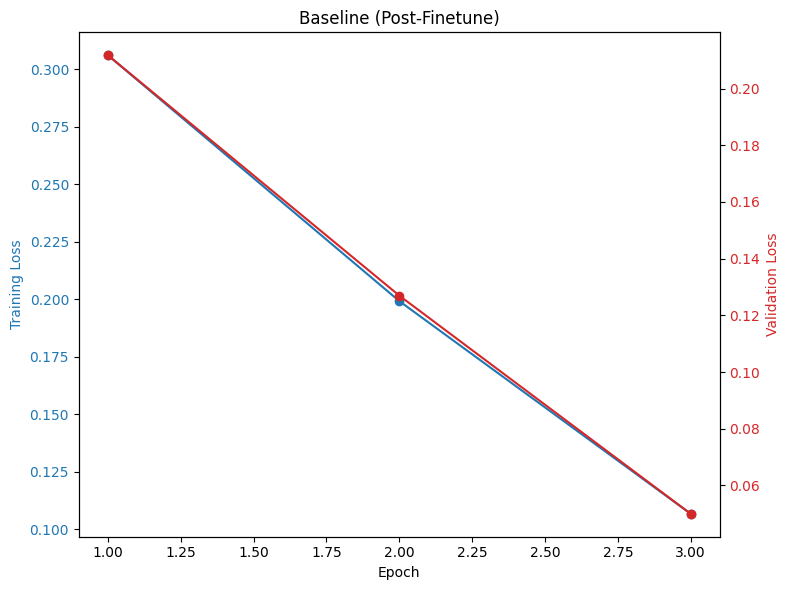

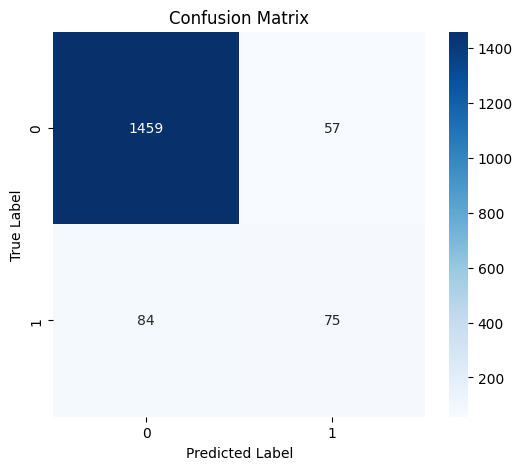

Test Accuracy: 0.915821
Test F1 Score: 0.734685


In [16]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 5min per epoch
finetune(model, train_loader, num_epochs = 3, plot_title="Baseline (Post-Finetune)")

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader, plot_confusion=True)

# Acc: 0.923591
# F1:  0.754404
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(basic_finetuned_dir)

### Reduce class imbalance via a weight loss function and/or weighted sampling

Weighted Loss:

In [16]:
import torch.nn as nn
def calculate_class_weights(data, num_labels = 2):
  labels = np.array([int(item["labels"]) for item in data])
  total = len(labels)

  counts = [np.sum(labels == class_label) for class_label in range(num_labels)]
  weights = [total / (2 * count) for count in counts]
  print(f"Class Weights: {[f"{label} : {weight:.4f}" for label, weight in enumerate(weights)]}")

  class_weights = torch.tensor(weights, dtype=torch.float).to(device)

  return class_weights

In [ ]:
class_weights = calculate_class_weights(internal_train_data)
weighted_loss = nn.CrossEntropyLoss(weight=class_weights)

Class Weights: ['0 : 0.5524', '1 : 5.2714']


00:25:09 - num_epochs = 10 | lr = 2e-05 | patience = 2
00:29:14 - Epoch 1/10 | Train Loss: 0.572255 | Validation Loss: 0.289771
00:33:19 - Epoch 2/10 | Train Loss: 0.385133 | Validation Loss: 0.175371
00:37:24 - Epoch 3/10 | Train Loss: 0.282871 | Validation Loss: 0.109896
00:41:30 - Epoch 4/10 | Train Loss: 0.173818 | Validation Loss: 0.070262
00:45:35 - Epoch 5/10 | Train Loss: 0.106452 | Validation Loss: 0.061069
00:49:40 - Epoch 6/10 | Train Loss: 0.075927 | Validation Loss: 0.027317
00:53:45 - Epoch 7/10 | Train Loss: 0.040914 | Validation Loss: 0.024579
00:57:50 - Epoch 8/10 | Train Loss: 0.020967 | Validation Loss: 0.008518
01:01:56 - Epoch 9/10 | Train Loss: 0.008718 | Validation Loss: 0.006766
01:06:01 - Epoch 10/10 | Train Loss: 0.005266 | Validation Loss: 0.004705


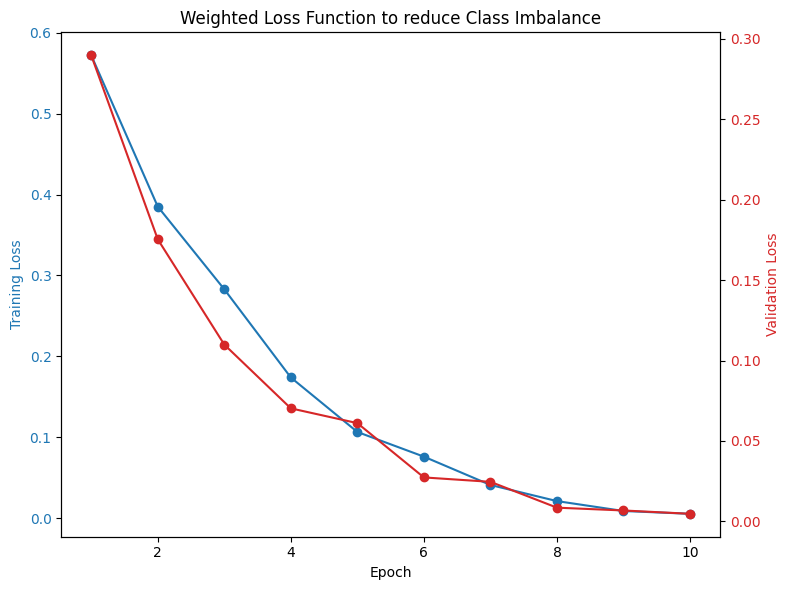

Test Accuracy: 0.919293
Test F1 Score: 0.766964


In [20]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(model, train_loader, plot_title="Weighted Loss Function to reduce Class Imbalance", loss_function=weighted_loss)

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  0.766964
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_dir)

Weighted Sampling:

In [17]:
from torch.utils.data import WeightedRandomSampler

def generate_sample_weights(data, class_weights):
  sample_weights = []
  for item in data:
    label = int(item["labels"])
    sample_weights.append(class_weights[label]) # using `weights` computed for weighted loss func

  return sample_weights

In [ ]:
sample_weights = generate_sample_weights(internal_train_data, class_weights)

sampler = WeightedRandomSampler(sample_weights, num_samples=len(internal_train_data), replacement=True)
weighted_train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)

01:18:17 - num_epochs = 10 | lr = 2e-05 | patience = 2
01:22:22 - Epoch 1/10 | Train Loss: 0.364785 | Validation Loss: 0.191153
01:26:27 - Epoch 2/10 | Train Loss: 0.131981 | Validation Loss: 0.085836
01:30:33 - Epoch 3/10 | Train Loss: 0.074955 | Validation Loss: 0.040819
01:34:38 - Epoch 4/10 | Train Loss: 0.038171 | Validation Loss: 0.010210
01:38:43 - Epoch 5/10 | Train Loss: 0.030190 | Validation Loss: 0.013433
01:42:48 - Epoch 6/10 | Train Loss: 0.019680 | Validation Loss: 0.005136
01:46:53 - Epoch 7/10 | Train Loss: 0.006162 | Validation Loss: 0.001822
01:50:59 - Epoch 8/10 | Train Loss: 0.008830 | Validation Loss: 0.002179
01:55:04 - Epoch 9/10 | Train Loss: 0.002880 | Validation Loss: 0.000395
01:59:09 - Epoch 10/10 | Train Loss: 0.003445 | Validation Loss: 0.001968


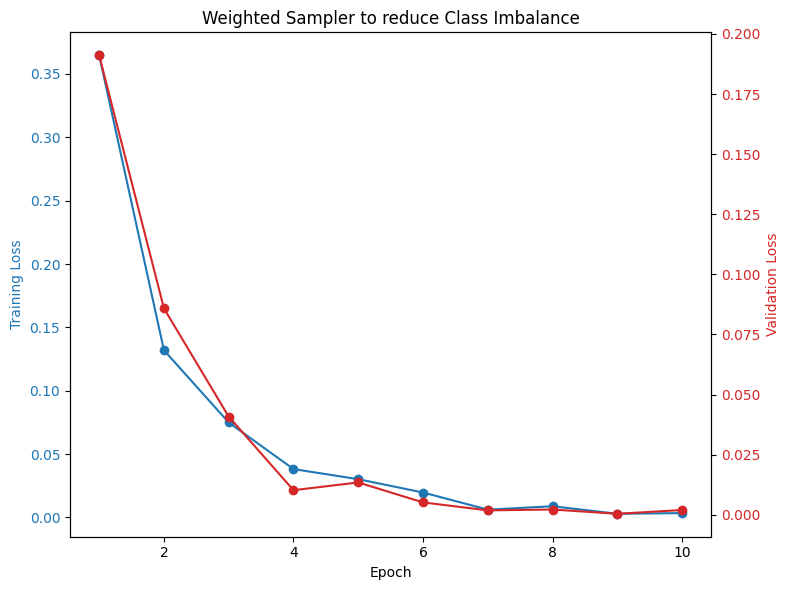

Test Accuracy: 0.923591
Test F1 Score: 0.738289


In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(model, weighted_train_loader, plot_title="Weighted Sampler to reduce Class Imbalance")

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: 0.923591
# F1:  0.738289
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_dir)

Try with Both Weighted Sampling and Weighted Loss Function:

In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(
  model, 
  weighted_train_loader, 
  plot_title="Weighted Sampler and Weighted Loss Function to reduce Class Imbalance", 
  loss_function=weighted_loss,
  lr=1e-6,
  num_epochs=5
)

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(weighted_loss_sampler_dir)

02:20:43 - num_epochs = 5 | lr = 1e-06 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### Data Augmentation to improve minority class representation

Synonym Replacement using `nlpaug`:

In [29]:
%pip install nlpaug
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.7 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import nlpaug.augmenter.word as naw
import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger_eng')

# new hyperparams
# how many words to replace with synonyms
AUG_MIN = 1
AUG_MAX = 2
AUG_P = 0.3
N_SAMPLES = 3

augmenter = naw.SynonymAug(aug_src='wordnet', aug_min=AUG_MIN, aug_max=AUG_MAX, aug_p=AUG_P)

[nltk_data] Downloading package wordnet to /homes/rk1121/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /homes/rk1121/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [20]:
# test augmenter 

text = internal_train_data[0]["text"]
print(text)
augmented = augmenter.augment(text, n=N_SAMPLES)

print(augmented)

H P S Verma says Ram Rahim SIngh was found guilty of raping two women followers at his ashram in 2002 . He says he will be taken to the central jail in the town of Rohtak . ( Pictured , supported gather beside a road leading to the court )
['H P S Verma says Ram Rahim SIngh embody found guilty of raping two women followers at his ashram in 2002. He says he will be taken to the central jail in the town of Rohtak. (Pictured, supported gather beside a road leading to the court )', 'Heat content P S Verma says Ram Rahim SIngh was found guilty of raping two women followers at his ashram in 2002. He says he will be taken to the central jail in the town of Rohtak. (Pictured, supported gather beside a route leading to the court )', 'H P S Verma says Ram Rahim SIngh was found guilty of raping two women followers at his ashram in 2002. He says he will be take to the central jail in the town of Rohtak. (Pictured, supported gather beside a road leading to the court )']


doesn't seem particularly great, but the effect may be minimal on the meaning, so may stil reduce class imbalance

In [23]:
def augment_data(data, augmenter):
  augmented_samples = []
  for item in data:
    label = item["labels"]
    if int(label) == 1:
      original_text = item["text"]

      samples = augmenter.augment(original_text, n=N_SAMPLES)

      for sample in samples:
        tokenized = tokenize(sample, tokenizer)
        tokenized = { key: value.squeeze(0).clone() for key, value in tokenized.items() }
        tokenized["labels"] = 1
        tokenized["text"] = original_text
        augmented_samples.append(tokenized)

  return data + augmented_samples


In [24]:
train_data_augmented = augment_data(internal_train_data, augmenter)
train_dataset_augmented = DontPatronizeMeDataset(train_data_augmented)

--- Train ---
{0: 6065, 1: 2540}
{0: '70.48%', 1: '29.52%'}
--- Test ---
{0: 1516, 1: 159}
{0: '90.51%', 1: '9.49%'}


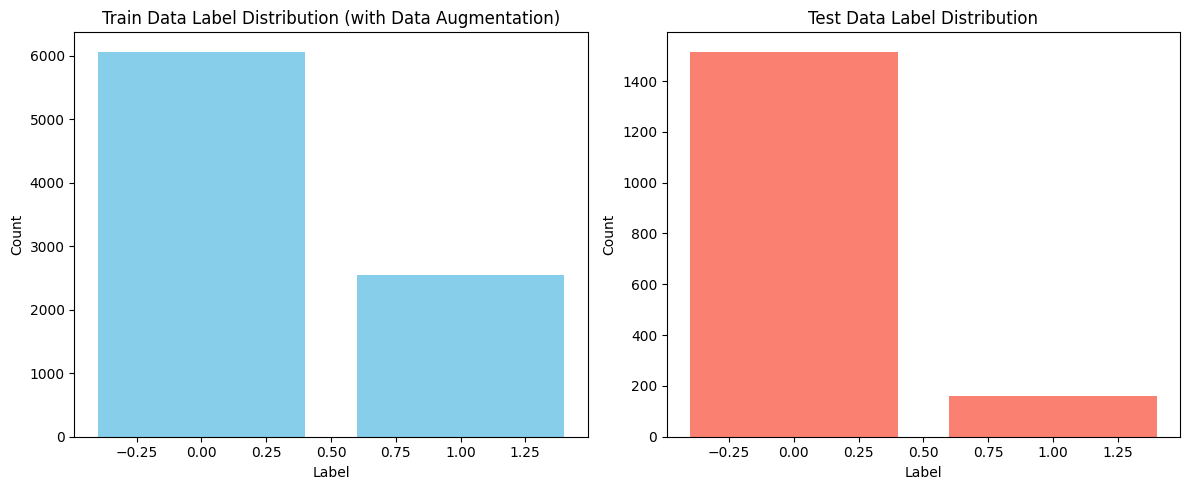

In [25]:
visualise_imbalance(train_data_augmented, internal_test_data, with_aug=True) 

In [20]:
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=16, shuffle=True, num_workers=4)

10:43:32 - num_epochs = 10 | lr = 2e-05 | patience = 2


/vol/venv/rk1121/nlp/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


10:48:48 - Epoch 1/10 | Train Loss: 0.310211 | Validation Loss: 0.216715
10:54:03 - Epoch 2/10 | Train Loss: 0.196108 | Validation Loss: 0.155710
10:59:17 - Epoch 3/10 | Train Loss: 0.146126 | Validation Loss: 0.067100
11:04:33 - Epoch 4/10 | Train Loss: 0.089613 | Validation Loss: 0.025933
11:09:47 - Epoch 5/10 | Train Loss: 0.044589 | Validation Loss: 0.010794
11:15:02 - Epoch 6/10 | Train Loss: 0.025196 | Validation Loss: 0.004671
11:20:17 - Epoch 7/10 | Train Loss: 0.013422 | Validation Loss: 0.001547
11:25:32 - Epoch 8/10 | Train Loss: 0.005645 | Validation Loss: 0.000699
11:30:47 - Epoch 9/10 | Train Loss: 0.003993 | Validation Loss: 0.000397
11:36:02 - Epoch 10/10 | Train Loss: 0.002562 | Validation Loss: 0.000323


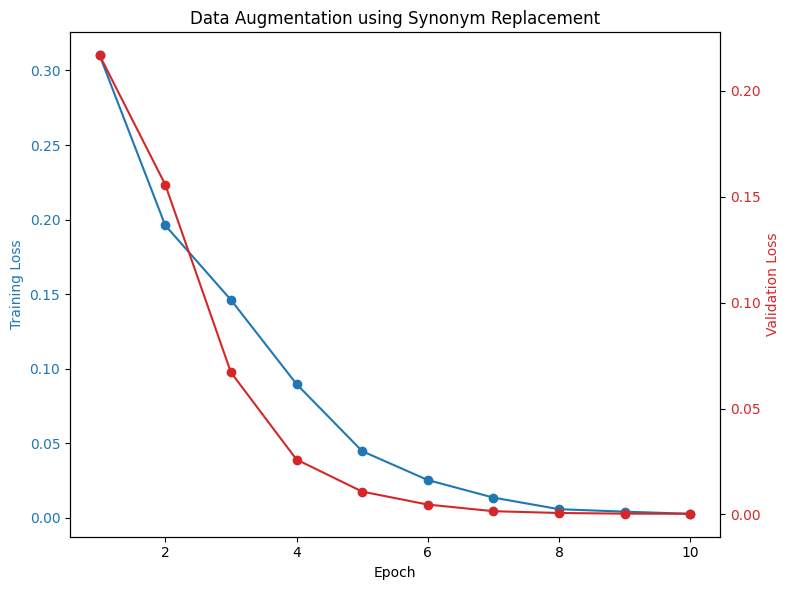

Test Accuracy: 0.917383
Test F1 Score: 0.745423


In [ ]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(model, train_loader_augmented, plot_title="Data Augmentation using Synonym Replacement")

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(augmented_dir)

### Combining Weighted Loss Function and Data Augmentation

In [17]:
import torch.nn as nn

train_labels = np.array([int(item["labels"]) for item in train_data_augmented])
total = len(train_labels)
num_classes = 2

counts = [np.sum(train_labels == class_label) for class_label in range(num_classes)]
weights = [total / (num_classes * count) for count in counts]
print(f"Class Weights: {[f"{label} : {weight:.4f}" for label, weight in enumerate(weights)]}")

class_weights = torch.tensor(weights, dtype=torch.float).to(device)
weighted_loss_augmented = nn.CrossEntropyLoss(weight=class_weights)

Class Weights: ['0 : 0.7095', '1 : 1.6935']


In [18]:
# seemed to cause massive overfitting when used alongside weighted loss

from torch.utils.data import WeightedRandomSampler

sample_weights = []
for item in train_data_augmented:
  label = int(item["labels"])
  sample_weights.append(weights[label]) # using `weights` computed for weighted loss func

sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data_augmented), replacement=True)
weighted_train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=16, sampler=sampler, num_workers=4)

In [22]:
torch.cuda.empty_cache()

model = RobertaForSequenceClassification.from_pretrained(raw_dir).to(device)

finetune(model, train_loader_augmented, plot_title="Data Augmentation & Weighted Loss Function", loss_function=weighted_loss_augmented)

test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(combined_dir)

13:09:48 - num_epochs = 10 | lr = 2e-05 | patience = 2
13:15:03 - Epoch 1/10 | Train Loss: 0.368848 | Validation Loss: 0.210933
13:20:18 - Epoch 2/10 | Train Loss: 0.228251 | Validation Loss: 0.171178
13:25:33 - Epoch 3/10 | Train Loss: 0.153274 | Validation Loss: 0.071703
13:30:48 - Epoch 4/10 | Train Loss: 0.098406 | Validation Loss: 0.037709
13:36:02 - Epoch 5/10 | Train Loss: 0.053519 | Validation Loss: 0.009967
13:41:17 - Epoch 6/10 | Train Loss: 0.027415 | Validation Loss: 0.009067
13:46:31 - Epoch 7/10 | Train Loss: 0.012001 | Validation Loss: 0.005771
13:51:46 - Epoch 8/10 | Train Loss: 0.009257 | Validation Loss: 0.001507
13:57:01 - Epoch 9/10 | Train Loss: 0.002621 | Validation Loss: 0.000140
14:02:15 - Epoch 10/10 | Train Loss: 0.002103 | Validation Loss: 0.000266


NameError: name 'plot_losses' is not defined

In [25]:
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: ???
# F1:  ???
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(combined_dir)

Test Accuracy: 0.914040
Test F1 Score: 0.755602


### Hyperparameter Search (via grid search)

In [22]:
import itertools

def hyperparam_search(
  train_data,
  val_loader,
  lrs = [1e-5, 2e-5, 1e-6, 5e-6],
  patiences = [1, 2],
  epochs = [5, 10, 20],
  aug_mins = range(1, 3),
  aug_maxs = range(1, 8),
  aug_ps = [x / 10 for x in range(1, 5)],
  aug_samples = range(1, 5),
  with_aug = True,
  with_weighted_loss = True,
  with_weighted_sampling = False
):

  best_f1: float = 0.0
  best_params = None
  best_model_state = None

  param_grid = {
    "lr": lrs,
    "patience": patiences,
    "num_epochs": epochs,
    "aug_min": aug_mins,
    "aug_max": aug_maxs,
    "aug_p": aug_ps,
    "aug_n": aug_samples
  }

  keys = list(param_grid.keys())

  for values in itertools.product(*param_grid.values()):
    params = dict(zip(keys, values))

    aug_min = params.get("aug_min", 1)
    aug_max = params.get("aug_max", 3)
    if (aug_max < aug_min):
      continue
    
    lr = params.get("lr", 2e-5)
    patience = params.get("patience", 2)
    num_epochs = params.get("num_epochs", 10)

    aug_p = params.get("aug_p", 0.3)
    aug_n = params.get("aug_samples", 3)

    print("="*60)
    print(f"Testing hyperparams: {params}")
    print("="*60)

    if with_aug:
      augmenter = naw.SynonymAug(
          aug_src="wordnet",
          aug_min=aug_min,
          aug_max=aug_max,
          aug_p=aug_p
      )

      train_data = augment_data(train_data, augmenter) 

    train_dataset = DontPatronizeMeDataset(train_data)

    if with_weighted_loss or with_weighted_sampling:
      class_weights = calculate_class_weights(train_data)

    if with_weighted_sampling:
      sample_weights = generate_sample_weights(train_data, class_weights)
      sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_data_augmented), replacement=True)
      train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=4)
    else:
      train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

    torch.cuda.empty_cache()

    model = RobertaForSequenceClassification.from_pretrained(raw_dir)
    model.to(device)

    if with_weighted_loss:
      loss_function = nn.CrossEntropyLoss(weight=class_weights)
      finetune(
        model=model,
        loader=train_loader,
        num_epochs=num_epochs,
        lr=lr,
        patience=patience,
        plot=False,
        loss_function=loss_function
      )
    else:
      finetune(
        model=model,
        loader=train_loader,
        num_epochs=num_epochs,
        lr=lr,
        patience=patience,
        plot=False,
        loss_function=loss_function
      )

    val_acc, val_f1 = evaluate(model, val_loader)

    print(f"Validation Acc = {val_acc:.4f} | Validation F1 = {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_params = params
        best_model_state = model.state_dict()

    print("\n===== Hyperparameter Search Complete =====")
    print(f"Best F1: {best_f1:.4f}")
    print(f"Best Params: {best_params}")

    
    model.load_state_dict(best_model_state)
    return best_params, best_model_state, best_f1, model
      

In [ ]:
torch.cuda.empty_cache()
params, model_state, f1, model = hyperparam_search(internal_train_data, test_loader)

model.to(device)
model.save_pretrained(optimal_dir)

Testing hyperparams: {'lr': 1e-05, 'patience': 1, 'num_epochs': 5, 'aug_min': 1, 'aug_max': 1, 'aug_p': 0.1, 'aug_n': 1}
Class Weights: ['0 : 0.7095', '1 : 1.6935']
17:15:12 - num_epochs = 5 | lr = 1e-05 | patience = 1
17:20:26 - Epoch 1/5 | Train Loss: 0.288814 | Validation Loss: 0.143998
17:25:41 - Epoch 2/5 | Train Loss: 0.159533 | Validation Loss: 0.093220
17:30:56 - Epoch 3/5 | Train Loss: 0.090749 | Validation Loss: 0.059689
17:36:10 - Epoch 4/5 | Train Loss: 0.034975 | Validation Loss: 0.020378
17:41:25 - Epoch 5/5 | Train Loss: 0.016880 | Validation Loss: 0.004756
Validation Acc = 0.9202 | Validation F1 = 0.7600

===== Hyperparameter Search Complete =====
Best F1: 0.7600
Best Params: {'lr': 1e-05, 'patience': 1, 'num_epochs': 5, 'aug_min': 1, 'aug_max': 1, 'aug_p': 0.1, 'aug_n': 1}


### Evaluate the final model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(optimal_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader)

# Acc: 0.923591
# F1:  0.754404
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Test Accuracy: 0.914040
Test F1 Score: 0.755602


### Load test data

In [ ]:
TEST_DATA_PATH = "data/task4_test.tsv"

column_names = ["par_id", "art_id", "keyword", "country", "text"]
test_data = pd.read_csv(TEST_DATA_PATH, sep="\t", header=None, names=column_names)

print("Test Data shape:", test_data.shape)

# print(test_text_data.head())

test_dataset = DontPatronizeMeDataset(test_data, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


Test Data shape: (3832, 5)


In [32]:
full_dev_dataset = DontPatronizeMeDataset(text_data, tokenizer, max_length=128)
full_dev_loader = DataLoader(full_dev_dataset, batch_size=16, shuffle=False, num_workers=4)

In [35]:
model = RobertaForSequenceClassification.from_pretrained(basic_finetuned_dir).to(device)

print("Generating predictions for Dev...")
predict(model, full_dev_loader, save_path="dev.txt")

print("Generating predictions for Test...")
predict(model, test_loader, save_path="test.txt")


Generating predictions for Dev...
Generating predictions for Test...


[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
